In [11]:
%matplotlib notebook
from IPython.display import HTML
HTML(open("style.css", "r").read())
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy
from codes import examples

# Алгоритм художника. BSP-дерево


Одной из важных задач визуализации объектов является определение местоположений объектов сцены для точки наблюдения - их сортировка в порядке удаления и обнаружение столкновений, перекрытий.

> __Постановка задачи. __
Пусть дана плоскость с 2D или 3D объектами и точка наблюдения над ней. Нужно отрисовать на сцене видимые из точки наблюдения части объектов.

## Простой алгоритм отрисовки сцены

Простой алгоритм для удаления невидимых частей объектов - **алгоритм z-буфера**. Для плоскости отрисовки в направлении просмотра проводится ось z-координат и определяется, какие пиксели покрывают проекции объектов.

Алгоритм, просматривая каждый объект хранит информацию в двух буферах - буфере кадра и z-буфере:
* В буфере кадра для каждого пикселя хранится о цвете объекта, отображаемого им в данный момент
* В z-буфере для каждого пикселя хранится z-координата точки видимого на данный момент объекта. Получается для каждого пикселя мы перебираем объекты:
    * Если z-координата объекта в пикселе меньше, чем z-координата пикселя в z-буфере, то новый объект лежит перед видимым на данный момент. Тогда запишем цвет нового объекта в буфер кадра, а его координату для пикселя в z-буфер
    * Если z-координата объекта в пикселе больше, чем z-координата пикселя в z-буфере, то новый объект невидим и буферы не изменяются

Алгоритм z-буфера довольно легко реализовать, но хоть он достаточно быстро работает, у него есть недостатки в виде потерь большого количества памяти для хранения z-буфера и дополнительных проверок каждого пикселя для каждого объекта.

## Алгоритм художника

Алгоритм художника работает без дополнительных затрат памяти, изначально сортируя объекты по расстоянию от них до точки обзора. Тогда объекты сразу проверяются в порядке "глубины", исключая проверку z-координаты, ведь теперь мы всегда пишем цвет в буфер кадра.
<img src="images\img_01_imposition.png" style="width: 500px; float: midle" />

Получается нужно уметь быстро сортировать объекты, но это не всегда просто, иногда отношение "лежит перед" содержит циклы (рис. 1). Когда циклическое перекрытие происходит, нужно разрывать циклы, разбивая один или больше объектов на части.

<img src="images\img_02_cycles.png" style="width: 200px; float: midle" />
<i><center>Рисунок 1. Пример цикла наложений объектов</center></i>

Заметим что порядок сортировки объектов зависит от положения точки обзора, то есть мы должны пересчитывать её при каждом смещении наблюдателя. Чтобы использовать этот алгоритм в реальной жизни, например, в симуляторе полета, хочется предпосчитать сцену так, чтобы можно было быстро найти порядок отборажения объектов для любой точки обзора.

Данную задачу можно решить с помощью техники **двоичного разбиения пространства**(англ. binary space partitioning, BSP)

## Структура BSP-дерева

Двоичное разбиение пространства в 2D случае строится с помощью рекурсивного разбиения плоскости прямыми. На примере (рис. 2) для всей плоскости проводится прямая $l_1$, разбивая её на полуплоскость выше $l_1$ и ниже. Затем, для каждой полуплоскости проводятся свои прямые - $l_2$ и $l_3$ опять разбивая части к которым они относятся, ещё на 2 каждую. И так далее.

<img src="images\img_03_tree_example.png" style="width: 700px; float: midle" />
<i><center>Рисунок 2. Пример дерева, построенного для разбиения</center></i>

Прямые разбивают на части не только плоскость, но и объекты, расположенные на ней - разбиение продолжается, пока внутри каждой грани плоскости окажется не более одного фрагмента объекта.

Весь процесс можно предстваить в виде двоичного дерева - BSP-дерева. Каждый его лист соответствует грани разбиения, в нем хранится фрагмент объекта из этой грани; каждый узел дерева соответствует разбивающей прямой, которая находится в этом узле.

> __Определение. __ 
**BSP-дерево** - дерево, отвечающее заданному двоичному разбиению пространства.

**В общем случае d-мерного гиперпространства:**

Для d-мерной гиперплоскости h: $a_1x_1 + a_2x_2 +...+ a_dx_d + a_{d+1} = 0$
разбиением гиперпространства можно считать разделение его на два множества:
* $h^+ = \{(x_1,x_2,...,x_d):a_1x_1 + a_2x_2 + ... + a_dx_d + a_{d+1} > 0\}$
* $h^- = \{(x_1,x_2,...,x_d):a_1x_1 + a_2x_2 + ... + a_dx_d + a_{d+1} < 0\}$

Пусть S - множество объектов, для которого мы строим разбиение d-мерном пространстве, тогда BSP-дерево с v-корневой вершиной - будет выглядеть:   
* Если $|S|\le1$, то v - лист. Фрагмент объекта S, если он существует, хранится в этом листе
* Если $|S|>1$, то в v хранится гиперплоскость $h_v$ и множество S, которые полностью содержатся в $h_v$. Левый ребенок v является корнем BSP-дерева на множестве $S^-=\{h^-_v\cap s\:|\:s \in S\}$. Правый ребенок - на множестве $S^+=\{h^+_v\cap s\:|\:s\in S\}$

**Размер BSP-дерева** равен суммарному размеру множеств во всех узлах, то есть число фрагментов, на которые были разбиты объекты. Так как BSP-дерево не содержит прямых разбивающих пустую грань (пустая грань уже ребенок), то количество узлов пропорционально размеру дерева.

В итоге, каждой вершине BSP-дерева можно сопоставить полигональную область, которая определяется как пересечение полуплоскостей $h^*_u$, где u - предок v, и
$* = \begin{cases}
-, если \:v \:- \:левый \:ребенок\\
+, если \:v \:- \:правый \:ребенок
\end{cases}$

Корню дерева соответствует все пространство

<img src="images\img_04_emphasizing.png" style="width: 700px; float: midle" />
<i><center>Рисунок 3. На примере выделенная область соответствует региону $l^+_1\cap l^+_2\cap l^-_3$</center></i>

При построении BSP-дерева могут использоваться любые разбивающие гиперплоскости, но в целях упрощения вычислений удобно ограничить множество  разбивающих гиперплоскостей. Обычно используют авто-разбиения.

> __Определение. __ 
В двумерном случае для множества отрезком разбиение, в котором используются разбивающие прямые, проходящие через один из данных отрезков, называется **авто-разбивающим**. В трехмерном случае авто-разбиение использует плоскости, которые содержат грани многогранников.

<img src="images\img_04.5_some_emphasizing.png" style="width: 200px; float: midle" />
<i><center>Рисунок 4. Пример авто-разбиений</center></i>

<img src="images\img_05_bad_emphasizing.png" style="width: 200px; float: midle" />
<i><center>Рисунок 5. Плохой случай для авто-разбиений</center></i>

Как видно из примера (рис. 5) размер дерева, построенного на авто-разбиении может не быть минимальным. Возможен случай, когда размер BSP-дерева будет $O(n^2)$, где n - мощность множества объектов.

## BSP-деревья и алгоритм художника

Пусть мы построили BSP-дерево(T) для множества объектов(S) в трехмерном пространстве - используем его для получения "порядка глубины" из алгоритма художника.

Пусть $p_{view}$ -точка обзора , и он лежит над разбивающей плоскостью, хранимой в корне T.
<img src="images\img_06_division_review.png" style="width: 200px; float: midle" />
Тогда ни один из обектов,лежащих под этой плоскостью, не может перекрыть ни один из объектов, лежащих выше неё. Таким образом, мы можем безопасно отрисовать фрагменты объектов из поддерева $T^-$ до отрисовки объектов из $T^+$. Порядок фрагментов объектов в поддеревьях определяется аналогично.

**Псевдокод**<br/>
void painters_algorithm(T, $p_{view}$):<br/>
    $\;$v $\leftarrow$ T.root<br/>
    $\;$if v — лист<br/>
        $\;$$\;$отрисовать фрагменты объектов из S(v)<br/>
    $\;$else if $p_{view} \in h_v^+$<br/>
        $\;$$\;$painters_algorithm($T^-, p_{view}$)<br/>
        $\;$$\;$отрисовать фрагменты объектов из S(v)<br/>
        $\;$$\;$painters_algorithm($T^+, p_{view}$)<br/>
    $\;$else if $p_{view} \in h_v^-$<br/>
        $\;$$\;$painters_algorithm($T^+, p_{view}$)<br/>
        $\;$$\;$отрисовать фрагменты объектов из S(v)<br/>
        $\;$$\;$painters_algorithm($T^-, p_{view}$)<br/>
    $\;$else /∗ $p_{view} \in h_v$ ∗/<br/>
        $\;$$\;$painters_algorithm($T^+, p_{view}$)<br/>
        $\;$$\;$painters_algorithm($T^-, p_{view}$)

Эффективность данного алгоритма зависит от размера BSP-дерева, то есть необходимо выбирать разбивающие плоскости таким образом, чтобы деление объектов было минимальным.

BSP-деревья интересны тем, что позволяют достичь быстрой реализации удаления скрытых поверхностей для отрисовки сцены. А так как скорость - главная цель, следует упростить вид рассматриваемых объектов, поэтому далее будем считать, что в 3D мы работаем с многогранниками, грани которых уже триангулированы. Таким образом, множество S в трехмерном пространстве будет состоять только из треугольников.

<IPython.core.display.Javascript object>


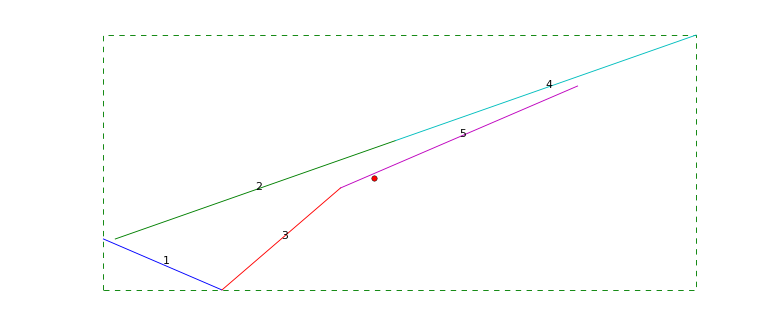

In [23]:
#визуализация алгоритма - нажатие на карту устанавливает наблюдателя и все линии (или их части) нумерутся в порядке их отрисовки
from codes.BSPTreeClasses  import *
s = []#набор непересекающихся отрезков
s.append(Segment(Point(100, 0), Point(0, 100)))
s.append(Segment(Point(100, 0), Point(200, 200)))
s.append(Segment(Point(10, 100), Point(500, 500)))
s.append(Segment(Point(200,200),Point(400,400)))
examples.painter_interactive(s)

## Построение BSP-дерева

Рассмотрим задачу отрисовки сцены в двумерном случае.
Пусть $S = \{s_1, s_2, ... s_n\}$ - множество непересекающихся отрезков на плоскости. Используем авто-разбиение, рассматривая прямые, содержащие один из отрезков.
Пусть l(s) -прямая,содержащая отрезок s

**BSPTree 2D_BSP_tree(S)**:<br/>
    $\;$if $|S| \leqslant 1$<br/>
        $\;$$\;$$T \leftarrow BSPTree(S)$ /* T будет листом, в котором хранится данное множество */<br/>
        $\;$$\;$return T<br/>
    $\;$else  /* используем $l(s_1)$ как разбивающую прямую */</tex><br/>
        $\;$$\;$$S^+ \leftarrow \{s \cap l^+(s_1) \mid s \in S\}$<br/>
        $\;$$\;$$T^+ \leftarrow $2D_BSP_tree$(S^+)$<br/>
        $\;$$\;$$S^- \leftarrow \{s \cap l^-(s_1) \mid s \in S\}$<br/>
        $\;$$\;$$T^- \leftarrow $2D_BSP_tree$(S^-)$<br/>
        $\;$$\;$$S_v \leftarrow \{s \in S \mid s \subset l(s_1)\}$<br/>
        $\;$$\;$$T \leftarrow BSPTree(S_v,\ T^-,\ T^+) $<br/>
        $\;$$\;$ // создаем BSP-дерево c корнем в вершине v, левым поддеревом $T^-$ и правым поддеревом $T^+$ <br/>
        $\;$$\;$ // и множеством хранимых объектов $S_v$<br/>
        $\;$$\;$ return T<br/>                 


Данный алгоритм создаёт BSP-дерево для S, но оно не будет наименьшим в общем случае. Можно придумать стратегии выбора прямой разбиения - возможным подходом является выбок отрезка такого, что l(s) пересекает наименьшее число отрезков, однако поиск такого отрезка довольно затратно.

Выбор прямой довольно сложен, одним из наименее затратных и простых выборов является случайный. Это означает, что для разбиения мы будем использовать случайно выбранный отрезок - для этого перед построением дерева расположим отрезки S в случайном порядке.

Перед анализом рандомизированного алгоритма рассмотрим оптимизацию:
Предположим,что мы выбрали несколько первых разбивающиз прямых. Эти прямые порождают разбиение плоскости, грани которой соответствуют каким-то узлам BSP-дерева.
Рассмотрим какую-нибудь грань(f). В можестве S могут быть отрезки, которые полностью пересекают f. Выбор одного из таких отрезков для разбиения f не вызовет дробления других отрезков внутри f, и сам больше не будет рассматриваться. Назовем такое разбиение **свободным**.
<img src="images\img_07_free_split.png" style="width: 200px; float: midle" />
Улучшенная стратегия предполагает использование свободных разбиений везде, где можно и использвание случайных разбиений в противном случае. Чтобы определять, вызывает ли отрезок свободное разбиение, сопоставим каждому отрезку две булевые переменные, которые покажут, лежат ли правый и левый концы отрезка на какой-то разбивающей прямой. Если они обе истинны - отрезок вызывает свободное разбиение.

В итоге улучшения кода для BSP-дерева выглядят _приблизительно_ так:
 <details id="custom"><summary><span>Рандомизированная обёртка над деревом</span></summary>
```python
def Random_BSPTree(s: [Segment]):
    """Рандомизированное дерево"""
    #добавляем возможность улавливать свободное разбиение
    sUpgraded = [TreeSegm]
    for s1 in s:
        sUpgraded.append(TreeSegm(s1.a,s1.b,False,False))
    #случайно перемешаем для случайности данных
    random.shuffle(sUpgraded)
    return BSPTree(sUpgraded)
```
</details>
 <details id="custom"><summary><span>Отрезок для свободных разбиений</span></summary>
   <p>
```python
class TreeSegm:
    """Класс описывающий отрезок"""
    def __init__(self, a: Point, b: Point, aFlag:bool, bFlag:bool):
        self.a = a
        self.b = b
        self.aFlag=aFlag
        self.bFlag=bFlag

    def turn(self, p: Point):  # сравнить, в положительное или отрицательное полупространство попадает точка
        tax = self.a.x; tay = self.a.y; tbx = self.b.x; tby = self.b.y; tpx = p.x; tpy = p.y
        return tax * tby - tax * tpy + tay * tpx - tay * tbx + tbx * tpy - tby * tpx

    def cross(self, p1: Point, p2: Point):#найдем точку пересечения нашего и данного отрезка
        x=((p1.x*p2.y-p2.x*p1.y)*(self.a.x-self.b.x)-(self.b.x*self.a.y-self.a.x*self.b.y)*(p2.x-p1.x))/((p1.y-p2.y)*(self.a.x-self.b.x)-(self.b.y-self.a.y)*(p2.x-p1.x))
        y=((self.b.y-self.a.y)*x - (self.b.x*self.a.y-self.a.x*self.b.y))/(self.a.x-self.b.x)
        return Point(x,y)
```
</p></details>

Полная реализация BSP-дерева находится в файле [TMapClasses.py](TMapClasses.py).

## Оценка алгоритма

Оценим производительность алгоритма **2D_random_BSP_tree**. Для упрощения рассуждений будем анализироваль версию без свободных разбиений (асимптотической разницы между ними нет).

Размер BSP-дерева равен числу полученных фрагментов, которое зависит от сгенерированной перестановки отрезков - некоторые могут породить маленькие, некоторые большие деревья. 

<img src="images\img_08_order_diff_example.png" style="width: 700px; float: midle" />
<i><center>Рисунок 6. Различия в порядке деления пространства.</center></i>
На примере (рис 6) рассматриваются 3 отрезка: в порядке (а) они генерируют 5 фрагментов, в порядке (b) - всего 3.

Так как выбор отрезков случайный, будем оценивать средний размер для всех n! перестановок отрезков.

> __Лемма. __ 
Ожидаемое число фрагментов, сгенерированных алгоритмом **2D_random_BSP_tree** есть $O(n\log n)$.

$\triangleright$<div style="padding-left:40px">
Пусть $s_i$ - фиксированный отрезок из S. Посчитаем математическое ожидание количества отрезков, которые мы разрежем, когда $l(s_i)$ будет добавлена алгоритмом как следующая разбивающая прямая.
Постараемся понять, разрезается ли отрезок $s_j$ при добавлении прямой $l(s_i)$, в зависимости от отрезков, которые разрезаны $l(s_i)$, но находятся между $s_i$ и $s_j$. Когда прямая, пересекающая этот отрезок, добавляется раньше $l(s_i)$, она закрывает $s_j$ от $s_i$, например на (рис с примером 3, порядок b) отрезок $s_3$ защищен от  прямой $l(s_2)$ отрезком $s_1$, который был добавлен раньше.

Получается расстояние между отрезками $s_i$, $s_j$ можно определить как:
$dist(s_i,s_j) = \begin{cases}
|\,\{s \:между \:s_i \:и \:s_j \: |\,l(s_i)\cap s\neq \varnothing\}\,|, \:если \:l(s_i) \cap s_j \neq \varnothing\\
\infty ,\:иначе
\end{cases}$
<img src="images\img_09_dist_example.png" style="width: 300px; float: midle" />
Заметим, что для любого отрезка, может быть не более 2-х отрезков с одинаковым расстоянием до него - это те что лежат по разные стороны по прямой от $s_i$.

Пусть $k=dist(s_i,s_j)$ и $s_{j_1},...,s_{j_k}$ - отрезки между $s_i,s_j$. Найдем вероятность того, что при добавлении $l(s_i)$ разрежет $s_j$. Чтобы это произошло, $s_j$ не должен быть защищен от $s_i$, то есть $s_i$ должен быть рассмотрен раньше всех отрезков между $s_i,s_j$. Другими словами, среди множества индексов $\{i,j,j_1,...j_k\}$ индекс i должен быть наименьшим. Так как отрезки расположены в случайном порядке, получаем: $P(l(s_i)\cap s_j \neq \varnothing)\le \frac{1}{k+2}$. Это неравенство, так как могут существовать другие отрезки, с которыми $l(s_i)$ не пересекается, но они защищают $s_j$ от неё.
Теперь можно посчитать ожидание количества разрезов, происходящих при добавлении $s_i$:
$E(\text{числа разрезов при добавлении }s_i)\le \sum_{j\neq i} \frac{1}{dist(s_i,s_j)+2} \le 2 \sum^{n-2}_{k=0} \frac{1}{k+2} \le 2\ln n$

По линейности ожиданий можно заключить, что ожидаемое число разрезов при добавлении всех отрезков составляет не более $2n\log n$, так как изначально даны n отрезков, ожидаемое число фрагментов ограничено $n + 2n\log n$.
</div>
$\triangleleft$

Более того, хотя бы половина всех перестановок приводит к BSP-дереву размера $n+4n\log n$. Мы можем использовать это для нахождения дерева такого размера: после запуска алгоритма построения проверим высоту дерева, если больше $n+4n\log n$, запустим его ещё один раз - амортизированно число запусков алгоритма будет равно двум.

> __Теорема. __
В двумерном пространстве BSP-дерево размера $O(n\log n)$ может быть построено за ожидаемое время $O(n^2\log n)$.

$\triangleright$<div style="padding-left:40px">
Время работы алгоритма зависит от используемой перестановки, рассмотрим ожидаемое время работы. Нахождение случайной перестановки занимает $O(n)$ алгоритмом Фишера-Йетса. Если проигнорировать время рекурсивных вызвовов, то время работы линейно от количества фрагментов в S. Это число не превышает n, так как количество отрезков становится меньше с каждым рекурсивным вызовом. Число рекурсивных вызовов огрпничено количеством сгенерированных фрагментов, которое составляет $O(n\log n)$. Таким образом, время построения дерева составляет $O(n^2\log n)$.
</div>
$\triangleleft$

Описанный алгоритм обобщается и на трёхмерное пространство. Как было упомянуто выше, мы считаем что работаем в 3D с триангуляцией граней многогранников.
Пусть S -множество непересекающихся треугольников в пространстве, аналогично воспользуемся авто-разбиениями, разбивая пространство плоскостями, содержащими треугольники из S. Для треугольника обозначим плоскость, содержащую его как h(t).
<img src="images\img_10_3D_picture.png" style="width: 300px; float: midle" />
На вход алгоритму дается множество треугольников $S=\{t_1,t_2,...,t_n\}$.
Как и в 2D случае можно разбивать пространство плоскостями по теругольникам перемешав их случайным образом. **Свободные разбиения** в этом случае - ситуация когда треугольник из S полностью разделяет ячейку на две несвязанные подячейки.

## Размер BSP-деревьев в 3D пространстве

Для 3D модифицируем алгоритм - пусть плоскость генерируемая треугольником делит не только ячейку, в которой она находится, но и все остальные. Единственный вариант, когда мы не делим ячейку - если все объекты в ней и так уже находятся по одну сторону от плоскости.

<img src="images\img_11_3D_cell_split.png" style="width: 700px; float: midle" />
<i><center>Рисунок 7. Разделения в 3D алгоритме на примере 2D разделения.</center></i>
На примере (рис 7) рассматривается поведение алгоритмо: (а) - делит обычный; (b) - модифицированный. Заметим, что $l(s_2)$ продлжается после $l(s_1)$ хоть и рассматривается позже её, а вот $l(s_3)$ отсутвует в промежутке между $l(s_1)$ и $l(s_2)$, так как она там ничего не делит.

> __Лемма.__ Ожидаемое число фрагментов, генерируемый алгоритмом **3DRandomBSP2** в среднем $O(n^2)$

$\triangleright$<div style="padding-left:40px">
Найдем верхнюю границу ожидаемого количества частей, на который делится случайный треугольник $t_k$ из S. 
Для треугольника $t_i$ (i<k) определим прямую $l_i=h(t_i)\cap h(t_k)$. Множество $L=\{l_1, ..., l_{k-1}\}$ состоит из не более k-1 линий, лежащих в плоскости $h(t)k)$. Некоторые из этих линий пересекают $t_k$ - определим для них $s_i=l_i\cap t_k$.
Пусть I будет множеством всех $s_i$. Так как $t_k$ делится 
                             /*дописать*/
</div>
$\triangleleft$

Результат не очень впечатляет - квадратичный размер BSP-дерева - не то что хотелось бы при большом количсетве треугольников, однако следующая теорема показывает, что в общем случе мы не можем улучшить эту асимптммаотику, если будем испольщовать авто-разбиения.

>__Леммаю__ Всегда существуют множества из n непересакющихся 3D треугольников, для которых любое авто-разбиение даёт размер $\Omega (n^2)$.

$\triangleright$<div style="padding-left:40px">
Рассмотрим набор прямоугольников, состоящий из множества($R_1$) прямоугольников, параллельных плоскости x-y и множества ($R_2$) прямоугольников, параллельных  плоскости y-z. (Можно было сделать то же с треугольниками, но их сложнее представить)
<img src="images\img_12_Parall_Rect.png" style="width: 150px; float: midle" />
Пусть $n_1 = card(R_1), \:n_2=card(R_2)$, a $G(n_1,n_2)$ это минимальный размер авто-разбиения для этой конфигурации.
Утверждается, что $G(n_1,n_2)=(n_1 + 1)(n_2+1)-1$. Докажем это по индукции по $n_1 + n_2$.
    
$\triangleright$<div style="padding-left:40px">
    База очевидна для G(1,0) и G(0,1), рассмотрим случай $n_1 + n_2 >1$. Не уменьшая общности будем считать, что авто-разбиение выбрало прямоугольник (r) из $R_1$. Плоскость h(r) разделит все прямоугольники из $R_2$. Более того состояния обоих разделений, рассмотренных рекурсивно имеют одинаковую форму. Если m обозначает количество прямоугольников из $R_1$ лежащих выше r, тогда:
    $G(n_1,n_2) = 1 + G(m,n_2) + G(n_1 - m-1,n_2)=1+((m+1)(n_2+1)-1)+((n_1-m)(n_2+1)-1)=(n_1+1)(n_2+1)-1$
    </div>
    $\triangleleft$
</div>
$\triangleleft$

Возможно мы не должны ограничиваться авто-разбиениями. По оценке снизу из леммы мы показали что такое разбение будет давать квадратичное разбиение, однако мы можем легко получить BSP-дерево линейного размера, если отделим множество $R_1$ от $R_2$ плоскостью, параллельной x-z. Но даже незафиксированные разделения не смогут дать небольшое BSP-дерево для фигуры (рис 8). 

<img src="images\img_13_Bad_3D_case.png" style="width: 700px; float: midle" />
<i><center>Рисунок 8. Плохой для разбиения случай.</center></i>
Мы строим его, взяв сетку на плоскости, созданную из $n\2$ линий(точнее длинных тонких прямоугольников), параллельных оси х и $n\2$ линий параллельных оси y. Скосим их, чтобы получить пример с картинки, линии будут лежать на неком гиперболическом параболоиде. В конце немного сдвинем параллельные по у линии, чтобы они не пересекались. 

Формально фигуру можно представить множеством:
$\{y=i,z=ix: 1<=i<=n/2\}\cup\{x=i,z=iy+\epsilon : 1<=i<=n/2\}$, где $\epsilon$ - некая малая положительная константа.
В этом случае BSP должна пересечь хотя бы одну из 4-х линий, которые ограничивают соседнюю клетку.

<IPython.core.display.Javascript object>


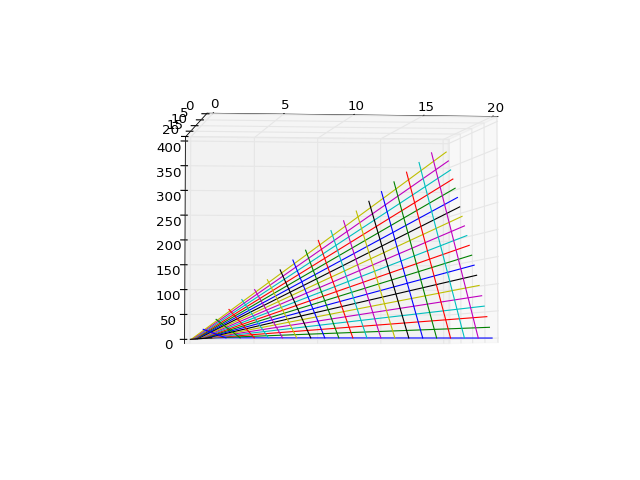

In [12]:
#модель плохого для разбиения случая, N=n/2; E - малая костанта
N,E=20,0.05
examples.show_bad_3D_example(N,E)

С помощью фигуры (рис 8) можно видеть, что для BSP-дерева всегда есть случаи, когда пространство делится на $\theta(n^2)$ ячеек. Неформально - для каждой клетки сетки мы не можем провести плоскость, которая пройдет через все 4 стороны, а значит каждая клетка даёт хотя бы 1 плоскость. Квадратичное количество клеток даёт квадратичное количество плоскостей разбиения для BSP-дерева.
>__Теорема.__ Для любой конфигурации непересекающихя 3D треугольников существует BSP-дерево размера $O(n^2)$. При этом, есть такие наборы треугольников, что любое BSP-дерево будет размера $\Omega (n^2)$.

Хотя и кажется, что деревья размера $\Omega(n^2)$ бесполезны, к счастью, это происходит не часто и, на практике, BSP-деревья работают хорошо даже для случая с авто-разбиениями.